# Fractional Differentiation

- 가격과 같은 비정상성의(non-stationary) 시계열 자료는 통계모형 등의 분석에 적합하지 않다. 따라서 보통 시계열 자료를 (정수 단위로; 1차, 2차 ...) 차분하여 정상적(stationary) 상태로 만들어 분석에 사용한다.

- 시계열이 비정상성이라는 것은 그만큼 메모리(memory)를 보존하고 있다는 것이다. 따라서 과도하게 차분을 하여 시계열을 정상적으로 만들면 기존의 시계열 자료가 가지고 있는 정보는 사라지게 된다.

- 이를 방지하기 위한 방법이 분수 차분(fractional differentiation)이다. "fractional differentiation"은 M.DePrado의 저서 "Advances in Financial Machine Learning"에 소개된 방법으로 시계열의 메모리를 어느정도 보존하면서 정상성을 만족하도록 차분해주는 것을 의미한다.

## 방법

다음과 같은 Backshift 연산자 $B$가 있다고 하자

실수 행렬 ${Xt}$에 대해 

- $B^k X_t = X_{t−k}$ ($k \geq 0$)
- $(1-B)^{d} = \sum^{\infty}_{k=0}{\left( \begin{array}{c}
      n \\
      r
    \end{array}\right)} (-B)^k$ (formal binomial series expansion)
    
- $(1-B)^{d}X_t$: d차 차분 시계열 (d는 실수)

따라서 d차 차분에 대해 다음과 같이 시계열이 생성된다.

- $\tilde{X}_t = \sum^{\infty}_{k=0}w_kX_{t-k}$
- $w = \{ 1, -d, \frac{d(d-1)}{2!}, -\frac{d(d-1)(d-2)}{3!}, \cdots, (-1)^k \prod_{i=1}^{k-1}(\frac{d-i}{k!}) , \cdots \}$

하지만 실제로 차분을 구할 때 위와 같은 계산은 무한급수가 되므로 이를 처리해야 한다.

또한 위의 식에서의 계수(혹은 weight)를 $w$(예: $0.2, 0.08 \cdots$)라고 했을 때, 정수가 아닌 $d$에 대해 $k \geq d+1$가 되면 $\text{int}[d]$가 짝수일 때 $w$가 음수가 된다. 

즉, $\text{int}[d]$가 짝수일 때, $\lim\limits_{k\to \infty} w_k = 0^-$이고, $\text{int}[d]$가 홀수일 때, $\lim\limits_{k\to \infty} w_k = 0^+$이다.

따라서 $w_k$의 $k$에 대한 window를 정해주거나, 상대적 weight-loss ($\frac{\sum_{j=T-1}^{T}|w_j|}{\sum_{i=0}^{T-1}|w_i|}$)에 대해 threshold를 설정하여 계산을 제한할 수 있다.

예를 들어 다음과 같이 생각할 수 있다.

- $(1-B)^{0.2} X_t = X_t - 0.2 X_{t-1} - 0.08 X_{t-2} - 0.048 X_{t-3} \cdots$
- $(1-B)^{0.4} X_t = X_t - 0.4 X_{t-1} - 0.12 X_{t-2} - 0.064 X_{t-3} \cdots$
- $(1-B)^{0.8} X_t = X_t - 0.8 X_{t-1} - 0.08 X_{t-2} - 0.032 X_{t-3} \cdots$
- $(1-B)^{1} X_t = X_t - 1.0 X_{t-1} - 0 X_{t-2} - 0 X_{t-3} \cdots$

## 예시

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import fracdiff # https://github.com/fracdiff/fracdiff를 사용

In [9]:
# S&P500 지수를 가져와본다

sp500 = yf.download('^GSPC', start='2001-1-1', end='2023-1-1').Close

[*********************100%***********************]  1 of 1 completed


In [10]:
sp500

Date
2001-01-02    1283.270020
2001-01-03    1347.560059
2001-01-04    1333.339966
2001-01-05    1298.349976
2001-01-08    1295.859985
                 ...     
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
2022-12-30    3839.500000
Name: Close, Length: 5535, dtype: float64

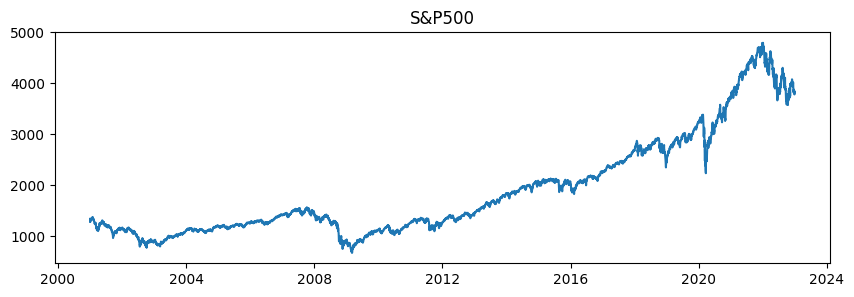

In [11]:
plt.figure(figsize=(10,3))
plt.title("S&P500")
plt.plot(sp500)
plt.show()

In [12]:
# fraction difference (n=1)은 np.diff()와 같다.

diff = sp500.diff()[1:]
f_diff_1 = fracdiff.fdiff(sp500, n=1)
np.all(diff == f_diff_1)

True

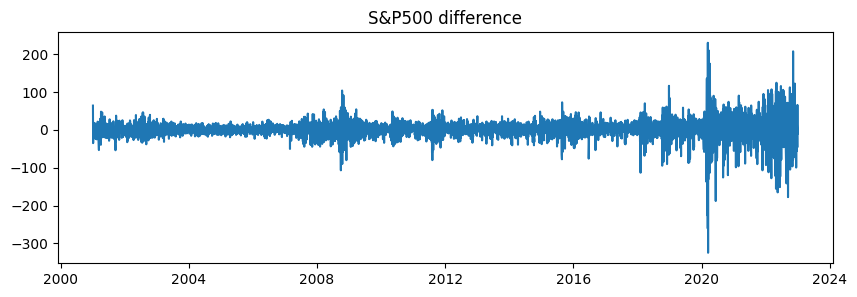

In [13]:
diff = sp500.diff()
plt.figure(figsize=(10,3))
plt.title("S&P500 difference")
plt.plot(diff)
plt.show()

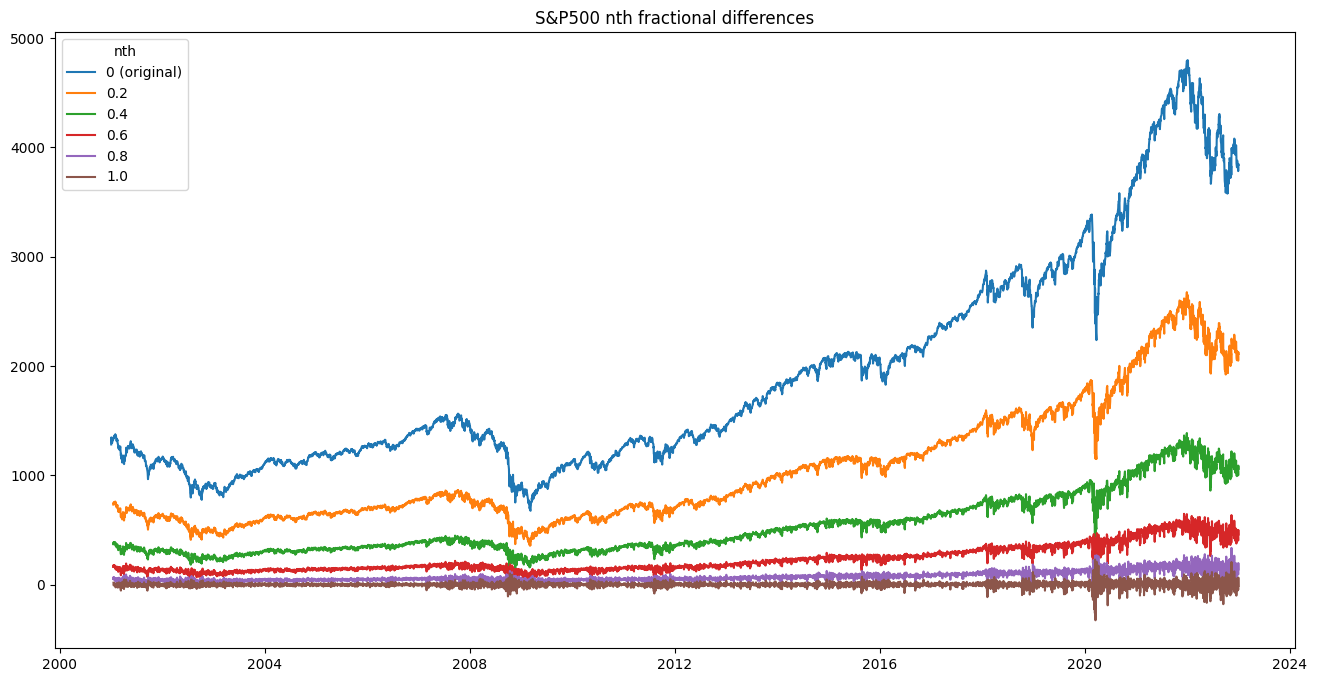

In [14]:
n_s=[.2,.4,.6,.8,1.]
w=10
plt.figure(figsize=(16,8))
plt.title(f"S&P500 nth fractional differences")
plt.plot(sp500)
for n in n_s:
    diff = fracdiff.fdiff(sp500, n=n, window=w)[w:]
    diff = pd.Series(diff,index=sp500.index[int(n)+w:])
    plt.plot(diff)
plt.legend(['0 (original)']+n_s, title='nth')
plt.savefig("fdiff_thumbnail.jpg")
plt.show()

## 참고문헌

- De Prado, M. L. (2018). Advances in financial machine learning. John Wiley & Sons.
- https://fracdiff.github.io/fracdiff/